In [2]:
#-----import packages-----#

#common python packages
import numpy as np
import string
import random
import os
import pickle
import argparse
import wget
import math
import gc
import matplotlib.pyplot as plt
from datetime import datetime
from tempfile import TemporaryFile

#biological packages
import pybedtools
from pybedtools import featurefuncs
import pyBigWig

#machine learning packages
import sklearn
from sklearn import metrics
from sklearn.utils import shuffle, class_weight
from matplotlib import pyplot as plt
import pandas as pd

import tensorflow as tf

import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, GlobalAveragePooling2D, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras.utils import Sequence, plot_model
from keras.constraints import unit_norm
from keras import regularizers
from keras.callbacks import EarlyStopping, Callback, TensorBoard, ReduceLROnPlateau
import keras_metrics as km
from keras.models import load_model

from models.v3 import create_model
from models.custom_metrics import auroc, auprc, recall_m, precision_m, f1_m

#notify the OS about GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'

Using TensorFlow backend.


In [3]:
#parsing command line arguments
# -----parsing command line arguments-----#
parser = argparse.ArgumentParser(description='Training CNN model to predict STARR-seq enhancers based on chromatin accessbility and histone marks')
parser.add_argument('-c', '--cell_types', type=str, help='comma separated string of cell_types')
parser.add_argument('-i', '--in_dir', type=str, help='directory containing 01_data_encoding intermediate tsv files')

#simulate command line input
cmdline_str='-c ' + " HepG2,K562 " + \
    ' -i ' + "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/encoded_2overlap/ATAC/"

seq_names = ["ATAC", "H3K27ac", "H3K4me3", "H3K9ac", "H3K4me1"]

#check if the files are there
args = parser.parse_args(cmdline_str.split())
args.cell_types = args.cell_types.split(",")
for cell in args.cell_types:
    for seq in seq_names:
        pos_file = args.in_dir + cell + "." + seq + ".pos.tsv"
        if not os.path.exists(pos_file):
            print(pos_file + " file does not exist")
            exit(1)
        neg_file = args.in_dir + cell + "." + seq + ".neg.tsv"
        if not os.path.exists(neg_file):
            print(neg_file + " file does not exist")
            exit(1)
print("all files found!")

all files found!


In [4]:
with open(args.in_dir + "hg38_signals.pickle", 'rb') as f:
    X, y = pickle.load(f)
window_size = int(X.shape[2] * 10)
X, y = shuffle(X, y, random_state=0)
x_train = np.expand_dims(X, axis=4)
y_train = y

#calculate class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                  y_train.flatten())

KeyboardInterrupt: 

In [5]:
# construct the model
model = create_model(width=int(window_size/10))
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
adam = Adam(lr=5e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=9e-5)
model.compile(loss='binary_crossentropy', optimizer=adam, 
    metrics=['accuracy', auroc, auprc, f1_m, recall_m, precision_m])

if os.path.exists('./saved_models/ATAC_hg38.v3.h5'):
    model.load_weights('./saved_models/ATAC_hg38.v3.h5')
else:
    #train the model
    history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=100,
                        validation_split=0.1,
                        shuffle=True,
                        class_weight=class_weights,
                        callbacks=[es]) 

    model.save_weights('./saved_models/ATAC_hg38.v3.h5')

/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/models/v3.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  model = Model(input=[input_size], output=[pred_output])


Train on 142332 samples, validate on 15815 samples
Epoch 1/100
142332/142332 [==============================] - 133s 938us/step - loss: 0.0660 - acc: 0.9771 - auroc: 0.9508 - auprc: 0.8027 - f1_m: 0.7999 - recall_m: 0.8174 - precision_m: 0.8155 - val_loss: 0.0367 - val_acc: 0.9868 - val_auroc: 0.9924 - val_auprc: 0.9243 - val_f1_m: 0.8952 - val_recall_m: 0.9254 - val_precision_m: 0.8876
Epoch 2/100
142332/142332 [==============================] - 130s 912us/step - loss: 0.0328 - acc: 0.9880 - auroc: 0.9944 - auprc: 0.9390 - f1_m: 0.8830 - recall_m: 0.9102 - precision_m: 0.8756 - val_loss: 0.0312 - val_acc: 0.9893 - val_auroc: 0.9956 - val_auprc: 0.9483 - val_f1_m: 0.9098 - val_recall_m: 0.9315 - val_precision_m: 0.9046
Epoch 3/100
142332/142332 [==============================] - 130s 912us/step - loss: 0.0290 - acc: 0.9895 - auroc: 0.9961 - auprc: 0.9534 - f1_m: 0.8931 - recall_m: 0.9195 - precision_m: 0.8852 - val_loss: 0.0303 - val_acc: 0.9887 - val_auroc: 0.9965 - val_auprc: 0.9575 

In [12]:
with open("./mm10/mm10_signals.pickle", 'rb') as f:
    X,Y = pickle.load(f)

In [13]:
y_pred_list = []
accuracy_list = []
for i in range(len(samples)):
    y_pred = model.predict(X[i]).ravel()
    y_pred_list.append(y_pred)

    accuracy_s = sklearn.metrics.accuracy_score(Y[i], np.rint(y_pred))
    print(samples[i], "validation accuracy is:", accuracy_s)
    accuracy_list.append(accuracy_s)

forebrain validation accuracy is: 0.6672398968185727
heart validation accuracy is: 0.6947549441100602
hindbrain validation accuracy is: 0.6913155631986242
limb validation accuracy is: 0.6835769561478934
midbrain validation accuracy is: 0.6620808254514188
neural tube validation accuracy is: 0.704213241616509


In [14]:
y_pred_list = []
accuracy_list = []
for i in range(len(samples)):
    
    #fine-tuning
    X_ft = X.copy()
    X_ft.pop(i)
    X_ft = np.array(X_ft)
    X_ft = X_ft.reshape((-1, X_ft.shape[2], X_ft.shape[3], X_ft.shape[4]))
    
    Y_ft = Y.copy()
    Y_ft.pop(i)
    Y_ft = np.array(Y_ft)
    Y_ft = Y_ft.reshape((-1, 1))
    
    X_ft, Y_ft = shuffle(X_ft, Y_ft, random_state=0)
    
    class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(Y_ft),
                                                  Y_ft.flatten())
    
    es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    
    ft_model = create_model(width=int(window_size/10))
    ft_model.load_weights('./saved_models/ATAC_hg38.v3.h5')
    ft_model.compile(loss='binary_crossentropy', 
                     optimizer=Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=9e-5), 
                     metrics=['accuracy', auroc, auprc, f1_m, recall_m, precision_m])
    
    #train the model
    history = ft_model.fit(X_ft, Y_ft,
                        batch_size=4,
                        epochs=100,
                        validation_split=0.1,
                        shuffle=True,
                        class_weight=class_weights,
                        callbacks=[es])
    
    

    y_pred = ft_model.predict(X[i]).ravel()
    y_pred_list.append(y_pred)

    accuracy_s = sklearn.metrics.accuracy_score(Y[i], np.rint(y_pred))
    print(samples[i], "validation accuracy is:", accuracy_s)
    accuracy_list.append(accuracy_s)

/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/models/v3.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  model = Model(input=[input_size], output=[pred_output])


Train on 5233 samples, validate on 582 samples
Epoch 1/100
5233/5233 [==============================] - 26s 5ms/step - loss: 0.8370 - acc: 0.7185 - auroc: 0.6682 - auprc: 0.2431 - f1_m: 0.1689 - recall_m: 0.2031 - precision_m: 0.1616 - val_loss: 0.7153 - val_acc: 0.7990 - val_auroc: 0.6625 - val_auprc: 0.2264 - val_f1_m: 0.1125 - val_recall_m: 0.1214 - val_precision_m: 0.1140
Epoch 2/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.5543 - acc: 0.8316 - auroc: 0.6607 - auprc: 0.2197 - f1_m: 0.0414 - recall_m: 0.0414 - precision_m: 0.0455 - val_loss: 0.5908 - val_acc: 0.8574 - val_auroc: 0.6563 - val_auprc: 0.2156 - val_f1_m: 0.0206 - val_recall_m: 0.0206 - val_precision_m: 0.0206
Epoch 3/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.4932 - acc: 0.8552 - auroc: 0.6563 - auprc: 0.2141 - f1_m: 0.0141 - recall_m: 0.0132 - precision_m: 0.0161 - val_loss: 0.5329 - val_acc: 0.8660 - val_auroc: 0.6523 - val_auprc: 0.2108 - val_f1_m: 0.0000e+00 - 

Epoch 50/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3648 - acc: 0.8615 - auroc: 0.6927 - auprc: 0.2690 - f1_m: 0.0116 - recall_m: 0.0110 - precision_m: 0.0130 - val_loss: 0.3812 - val_acc: 0.8746 - val_auroc: 0.6929 - val_auprc: 0.2693 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 51/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3653 - acc: 0.8607 - auroc: 0.6931 - auprc: 0.2696 - f1_m: 0.0082 - recall_m: 0.0073 - precision_m: 0.0099 - val_loss: 0.3811 - val_acc: 0.8746 - val_auroc: 0.6932 - val_auprc: 0.2699 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 52/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3655 - acc: 0.8618 - auroc: 0.6934 - auprc: 0.2702 - f1_m: 0.0107 - recall_m: 0.0103 - precision_m: 0.0115 - val_loss: 0.3809 - val_acc: 0.8746 - val_auroc: 0.6935 - val_auprc: 0.2704 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

Epoch 75/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3629 - acc: 0.8618 - auroc: 0.6981 - auprc: 0.2797 - f1_m: 0.0111 - recall_m: 0.0106 - precision_m: 0.0122 - val_loss: 0.3778 - val_acc: 0.8746 - val_auroc: 0.6982 - val_auprc: 0.2799 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 76/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3640 - acc: 0.8616 - auroc: 0.6983 - auprc: 0.2800 - f1_m: 0.0138 - recall_m: 0.0130 - precision_m: 0.0153 - val_loss: 0.3777 - val_acc: 0.8746 - val_auroc: 0.6983 - val_auprc: 0.2802 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 77/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3639 - acc: 0.8618 - auroc: 0.6984 - auprc: 0.2803 - f1_m: 0.0117 - recall_m: 0.0104 - precision_m: 0.0145 - val_loss: 0.3776 - val_acc: 0.8746 - val_auroc: 0.6985 - val_auprc: 0.2805 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

Epoch 100/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3620 - acc: 0.8603 - auroc: 0.7012 - auprc: 0.2860 - f1_m: 0.0115 - recall_m: 0.0107 - precision_m: 0.0130 - val_loss: 0.3759 - val_acc: 0.8746 - val_auroc: 0.7012 - val_auprc: 0.2861 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
forebrain validation accuracy is: 0.8314703353396389
Train on 5233 samples, validate on 582 samples
Epoch 1/100
5233/5233 [==============================] - 26s 5ms/step - loss: 0.8748 - acc: 0.7158 - auroc: 0.6411 - auprc: 0.2263 - f1_m: 0.1764 - recall_m: 0.2117 - precision_m: 0.1694 - val_loss: 0.7093 - val_acc: 0.8041 - val_auroc: 0.6515 - val_auprc: 0.2251 - val_f1_m: 0.1168 - val_recall_m: 0.1249 - val_precision_m: 0.1249
Epoch 2/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.5754 - acc: 0.8265 - auroc: 0.6504 - auprc: 0.2198 - f1_m: 0.0462 - recall_m: 0.0459 - precision_m: 0.0507 - val_loss: 0.5847 - val_acc: 0.8574 - val_auro

Epoch 24/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3789 - acc: 0.8594 - auroc: 0.6689 - auprc: 0.2429 - f1_m: 0.0104 - recall_m: 0.0099 - precision_m: 0.0115 - val_loss: 0.3821 - val_acc: 0.8746 - val_auroc: 0.6693 - val_auprc: 0.2436 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 25/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3786 - acc: 0.8578 - auroc: 0.6698 - auprc: 0.2445 - f1_m: 0.0069 - recall_m: 0.0066 - precision_m: 0.0080 - val_loss: 0.3815 - val_acc: 0.8746 - val_auroc: 0.6703 - val_auprc: 0.2452 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 26/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3790 - acc: 0.8595 - auroc: 0.6708 - auprc: 0.2459 - f1_m: 0.0082 - recall_m: 0.0074 - precision_m: 0.0099 - val_loss: 0.3811 - val_acc: 0.8729 - val_auroc: 0.6711 - val_auprc: 0.2467 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

Epoch 49/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3736 - acc: 0.8584 - auroc: 0.6837 - auprc: 0.2683 - f1_m: 0.0116 - recall_m: 0.0106 - precision_m: 0.0138 - val_loss: 0.3750 - val_acc: 0.8711 - val_auroc: 0.6839 - val_auprc: 0.2686 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 50/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3729 - acc: 0.8592 - auroc: 0.6840 - auprc: 0.2689 - f1_m: 0.0134 - recall_m: 0.0127 - precision_m: 0.0153 - val_loss: 0.3749 - val_acc: 0.8711 - val_auroc: 0.6842 - val_auprc: 0.2692 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 51/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3721 - acc: 0.8590 - auroc: 0.6843 - auprc: 0.2696 - f1_m: 0.0139 - recall_m: 0.0129 - precision_m: 0.0164 - val_loss: 0.3748 - val_acc: 0.8711 - val_auroc: 0.6845 - val_auprc: 0.2698 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

Epoch 74/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3705 - acc: 0.8592 - auroc: 0.6895 - auprc: 0.2798 - f1_m: 0.0155 - recall_m: 0.0146 - precision_m: 0.0180 - val_loss: 0.3730 - val_acc: 0.8711 - val_auroc: 0.6895 - val_auprc: 0.2800 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 75/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3717 - acc: 0.8574 - auroc: 0.6896 - auprc: 0.2801 - f1_m: 0.0141 - recall_m: 0.0130 - precision_m: 0.0168 - val_loss: 0.3730 - val_acc: 0.8711 - val_auroc: 0.6897 - val_auprc: 0.2803 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 76/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3704 - acc: 0.8603 - auroc: 0.6898 - auprc: 0.2805 - f1_m: 0.0199 - recall_m: 0.0194 - precision_m: 0.0210 - val_loss: 0.3729 - val_acc: 0.8711 - val_auroc: 0.6899 - val_auprc: 0.2806 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

Epoch 99/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3717 - acc: 0.8601 - auroc: 0.6924 - auprc: 0.2864 - f1_m: 0.0222 - recall_m: 0.0214 - precision_m: 0.0237 - val_loss: 0.3720 - val_acc: 0.8711 - val_auroc: 0.6924 - val_auprc: 0.2864 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 100/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3701 - acc: 0.8588 - auroc: 0.6924 - auprc: 0.2865 - f1_m: 0.0161 - recall_m: 0.0150 - precision_m: 0.0183 - val_loss: 0.3719 - val_acc: 0.8711 - val_auroc: 0.6925 - val_auprc: 0.2867 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
heart validation accuracy is: 0.8469475494411006
Train on 5233 samples, validate on 582 samples
Epoch 1/100
5233/5233 [==============================] - 26s 5ms/step - loss: 0.8620 - acc: 0.7147 - auroc: 0.6740 - auprc: 0.2630 - f1_m: 0.1780 - recall_m: 0.2112 - precision_m: 0.1715 - val_loss: 0.6862 - val_acc: 0.8058 - val_auroc: 

Epoch 23/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3841 - acc: 0.8546 - auroc: 0.6772 - auprc: 0.2519 - f1_m: 0.0065 - recall_m: 0.0064 - precision_m: 0.0069 - val_loss: 0.3839 - val_acc: 0.8660 - val_auroc: 0.6776 - val_auprc: 0.2525 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 24/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3836 - acc: 0.8550 - auroc: 0.6782 - auprc: 0.2534 - f1_m: 0.0061 - recall_m: 0.0057 - precision_m: 0.0069 - val_loss: 0.3831 - val_acc: 0.8660 - val_auroc: 0.6786 - val_auprc: 0.2541 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 25/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3836 - acc: 0.8550 - auroc: 0.6791 - auprc: 0.2547 - f1_m: 0.0076 - recall_m: 0.0076 - precision_m: 0.0076 - val_loss: 0.3825 - val_acc: 0.8660 - val_auroc: 0.6795 - val_auprc: 0.2555 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000

Epoch 47/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3777 - acc: 0.8546 - auroc: 0.6919 - auprc: 0.2752 - f1_m: 0.0080 - recall_m: 0.0075 - precision_m: 0.0092 - val_loss: 0.3755 - val_acc: 0.8660 - val_auroc: 0.6920 - val_auprc: 0.2754 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 48/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3775 - acc: 0.8563 - auroc: 0.6921 - auprc: 0.2756 - f1_m: 0.0108 - recall_m: 0.0098 - precision_m: 0.0130 - val_loss: 0.3754 - val_acc: 0.8677 - val_auroc: 0.6923 - val_auprc: 0.2760 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 49/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3777 - acc: 0.8546 - auroc: 0.6925 - auprc: 0.2762 - f1_m: 0.0112 - recall_m: 0.0107 - precision_m: 0.0122 - val_loss: 0.3753 - val_acc: 0.8677 - val_auroc: 0.6927 - val_auprc: 0.2765 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision

Epoch 96/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3746 - acc: 0.8550 - auroc: 0.7012 - auprc: 0.2920 - f1_m: 0.0146 - recall_m: 0.0136 - precision_m: 0.0168 - val_loss: 0.3720 - val_acc: 0.8677 - val_auroc: 0.7012 - val_auprc: 0.2920 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 97/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3749 - acc: 0.8548 - auroc: 0.7013 - auprc: 0.2921 - f1_m: 0.0147 - recall_m: 0.0135 - precision_m: 0.0172 - val_loss: 0.3719 - val_acc: 0.8677 - val_auroc: 0.7013 - val_auprc: 0.2922 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 98/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3739 - acc: 0.8550 - auroc: 0.7014 - auprc: 0.2924 - f1_m: 0.0141 - recall_m: 0.0132 - precision_m: 0.0161 - val_loss: 0.3719 - val_acc: 0.8677 - val_auroc: 0.7014 - val_auprc: 0.2924 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
E

Epoch 45/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3702 - acc: 0.8599 - auroc: 0.6974 - auprc: 0.2760 - f1_m: 0.0192 - recall_m: 0.0186 - precision_m: 0.0206 - val_loss: 0.3498 - val_acc: 0.8763 - val_auroc: 0.6976 - val_auprc: 0.2763 - val_f1_m: 0.0183 - val_recall_m: 0.0172 - val_precision_m: 0.0206
Epoch 46/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3695 - acc: 0.8599 - auroc: 0.6979 - auprc: 0.2767 - f1_m: 0.0167 - recall_m: 0.0155 - precision_m: 0.0191 - val_loss: 0.3497 - val_acc: 0.8763 - val_auroc: 0.6980 - val_auprc: 0.2770 - val_f1_m: 0.0183 - val_recall_m: 0.0172 - val_precision_m: 0.0206
Epoch 47/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3687 - acc: 0.8584 - auroc: 0.6983 - auprc: 0.2774 - f1_m: 0.0132 - recall_m: 0.0124 - precision_m: 0.0153 - val_loss: 0.3496 - val_acc: 0.8763 - val_auroc: 0.6985 - val_auprc: 0.2777 - val_f1_m: 0.0183 - val_recall_m: 0.0172 - val_precision_m: 0.0206
E

Epoch 70/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3691 - acc: 0.8592 - auroc: 0.7044 - auprc: 0.2888 - f1_m: 0.0155 - recall_m: 0.0145 - precision_m: 0.0180 - val_loss: 0.3487 - val_acc: 0.8763 - val_auroc: 0.7045 - val_auprc: 0.2889 - val_f1_m: 0.0183 - val_recall_m: 0.0172 - val_precision_m: 0.0206
Epoch 71/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3686 - acc: 0.8586 - auroc: 0.7046 - auprc: 0.2891 - f1_m: 0.0139 - recall_m: 0.0121 - precision_m: 0.0176 - val_loss: 0.3487 - val_acc: 0.8763 - val_auroc: 0.7047 - val_auprc: 0.2892 - val_f1_m: 0.0183 - val_recall_m: 0.0172 - val_precision_m: 0.0206
Epoch 72/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3678 - acc: 0.8578 - auroc: 0.7048 - auprc: 0.2894 - f1_m: 0.0143 - recall_m: 0.0135 - precision_m: 0.0164 - val_loss: 0.3486 - val_acc: 0.8763 - val_auroc: 0.7049 - val_auprc: 0.2896 - val_f1_m: 0.0183 - val_recall_m: 0.0172 - val_precision_m: 0.0206
E

Epoch 95/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3664 - acc: 0.8603 - auroc: 0.7081 - auprc: 0.2960 - f1_m: 0.0203 - recall_m: 0.0190 - precision_m: 0.0229 - val_loss: 0.3483 - val_acc: 0.8763 - val_auroc: 0.7082 - val_auprc: 0.2962 - val_f1_m: 0.0183 - val_recall_m: 0.0172 - val_precision_m: 0.0206
Epoch 96/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3665 - acc: 0.8605 - auroc: 0.7082 - auprc: 0.2963 - f1_m: 0.0183 - recall_m: 0.0172 - precision_m: 0.0206 - val_loss: 0.3482 - val_acc: 0.8763 - val_auroc: 0.7083 - val_auprc: 0.2964 - val_f1_m: 0.0183 - val_recall_m: 0.0172 - val_precision_m: 0.0206
Epoch 97/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3675 - acc: 0.8584 - auroc: 0.7084 - auprc: 0.2966 - f1_m: 0.0155 - recall_m: 0.0149 - precision_m: 0.0172 - val_loss: 0.3482 - val_acc: 0.8763 - val_auroc: 0.7084 - val_auprc: 0.2966 - val_f1_m: 0.0183 - val_recall_m: 0.0172 - val_precision_m: 0.0206
E

Epoch 44/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3705 - acc: 0.8574 - auroc: 0.7030 - auprc: 0.2764 - f1_m: 0.0085 - recall_m: 0.0079 - precision_m: 0.0103 - val_loss: 0.3445 - val_acc: 0.8711 - val_auroc: 0.7032 - val_auprc: 0.2769 - val_f1_m: 0.0046 - val_recall_m: 0.0034 - val_precision_m: 0.0069
Epoch 45/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3723 - acc: 0.8582 - auroc: 0.7034 - auprc: 0.2773 - f1_m: 0.0125 - recall_m: 0.0111 - precision_m: 0.0153 - val_loss: 0.3444 - val_acc: 0.8711 - val_auroc: 0.7035 - val_auprc: 0.2775 - val_f1_m: 0.0046 - val_recall_m: 0.0034 - val_precision_m: 0.0069
Epoch 46/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3690 - acc: 0.8582 - auroc: 0.7038 - auprc: 0.2779 - f1_m: 0.0107 - recall_m: 0.0099 - precision_m: 0.0122 - val_loss: 0.3443 - val_acc: 0.8711 - val_auroc: 0.7040 - val_auprc: 0.2782 - val_f1_m: 0.0046 - val_recall_m: 0.0034 - val_precision_m: 0.0069
E

Epoch 69/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3682 - acc: 0.8599 - auroc: 0.7098 - auprc: 0.2890 - f1_m: 0.0157 - recall_m: 0.0149 - precision_m: 0.0172 - val_loss: 0.3436 - val_acc: 0.8711 - val_auroc: 0.7099 - val_auprc: 0.2892 - val_f1_m: 0.0046 - val_recall_m: 0.0034 - val_precision_m: 0.0069
Epoch 70/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3685 - acc: 0.8594 - auroc: 0.7100 - auprc: 0.2893 - f1_m: 0.0143 - recall_m: 0.0134 - precision_m: 0.0161 - val_loss: 0.3435 - val_acc: 0.8711 - val_auroc: 0.7101 - val_auprc: 0.2896 - val_f1_m: 0.0046 - val_recall_m: 0.0034 - val_precision_m: 0.0069
Epoch 71/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3683 - acc: 0.8594 - auroc: 0.7102 - auprc: 0.2896 - f1_m: 0.0153 - recall_m: 0.0149 - precision_m: 0.0161 - val_loss: 0.3435 - val_acc: 0.8711 - val_auroc: 0.7103 - val_auprc: 0.2899 - val_f1_m: 0.0046 - val_recall_m: 0.0034 - val_precision_m: 0.0069
E

5233/5233 [==============================] - 24s 5ms/step - loss: 0.4006 - acc: 0.8464 - auroc: 0.6806 - auprc: 0.2676 - f1_m: 0.0140 - recall_m: 0.0126 - precision_m: 0.0168 - val_loss: 0.3411 - val_acc: 0.8677 - val_auroc: 0.6811 - val_auprc: 0.2684 - val_f1_m: 0.0046 - val_recall_m: 0.0034 - val_precision_m: 0.0069
neural tube validation accuracy is: 0.9097162510748066


6 101 101


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


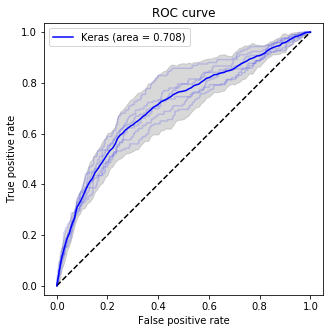

In [15]:
# ROC in test set
plt.figure(figsize=(5, 5))
base_fpr = np.linspace(0, 1, 101)
tpr_list = []
auroc_list = []
for i in range(len(Y)):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(Y[i], y_pred_list[i])
    auroc_list.append(sklearn.metrics.roc_auc_score(Y[i], y_pred_list[i]))
    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tpr_list.append(tpr)

print(len(tpr_list), len(tpr_list[0]), len(tpr_list[1]))
tpr_list = np.array(tpr_list)
mean_tpr = np.mean(np.array(tpr_list), axis=0)
tpr_std = tpr_list.std(axis=0)

tprs_upper = np.minimum(mean_tpr + 2 * tpr_std, 1)
tprs_lower = mean_tpr - 2 * tpr_std

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(base_fpr, mean_tpr, 'b', label='Keras (area = {:.3f})'.format(np.mean(np.array(auroc_list))))
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig(figure_output_name+'.ROC.png')

6 101 101


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


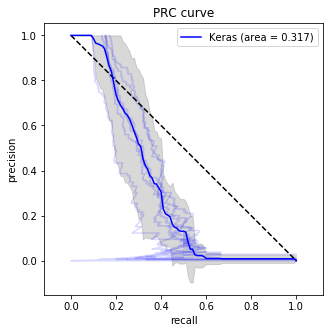

In [16]:
# PRC in test set
plt.figure(figsize=(5, 5))
base_recall = np.linspace(0, 1, 101)
precision_list = []
auprc_list = []
for i in range(len(Y)):
    recall, precision, thresholds = sklearn.metrics.precision_recall_curve(Y[i], y_pred_list[i])
    auprc_list.append(sklearn.metrics.average_precision_score(Y[i], y_pred_list[i]))
    plt.plot(recall, precision, 'b', alpha=0.15)
    precision = np.interp(base_recall, recall, precision)
    precision[0] = 1.0
    precision_list.append(precision)

print(len(precision_list), len(precision_list[0]), len(precision_list[1]))
precision_list = np.array(precision_list)
mean_precision = np.mean(np.array(precision_list), axis=0)
precision_std = precision_list.std(axis=0)

precisions_upper = np.minimum(mean_precision + 2 * precision_std, 1)
precisions_lower = mean_precision - 2 * precision_std

plt.plot([0, 1], [1, 0], 'k--')
plt.plot(base_recall, mean_precision, 'b', label='Keras (area = {:.3f})'.format(np.mean(np.array(auprc_list))))
plt.fill_between(base_recall, precisions_lower, precisions_upper, color='grey', alpha=0.3)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PRC curve')
plt.legend(loc='best')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig(figure_output_name+'.PRC.png')

In [17]:
for i in range(len(samples)):
    print("validated tissue " + samples[i] + " auROC: " + str(auroc_list[i]))

validated tissue forebrain auROC: 0.7229391820300912
validated tissue heart auROC: 0.7578455754771545
validated tissue hindbrain auROC: 0.7278209722556381
validated tissue limb auROC: 0.6813882454467003
validated tissue midbrain auROC: 0.6683025635736469
validated tissue neural tube auROC: 0.6921020688670321


In [18]:
for i in range(len(samples)):
    print("validated tissue " + samples[i] + " auPRC: " + str(auprc_list[i]))

validated tissue forebrain auPRC: 0.35929576857798373
validated tissue heart auPRC: 0.3431654902194813
validated tissue hindbrain auPRC: 0.3388482962045349
validated tissue limb auPRC: 0.3046925064590297
validated tissue midbrain auPRC: 0.31058617649802217
validated tissue neural tube auPRC: 0.2461515724776726
